In [62]:
import gpflow
from gpflow.utilities import print_summary

import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
import gym

# The lines below are specific to the notebook format
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

In [63]:
# collect gym environment data with MBRL policy in cartpole with different

data = np.load('data.npy')

# use the data to train the DPGP model, check the time used
a = 10
b = 2
alpha = stats.gamma.rvs(a, scale=1/b)
print(alpha)
# plot visualization
# x = np.linspace(stats.gamma.ppf(0.01, a, scale=1/b),
#                 stats.gamma.ppf(0.99, a, scale=1/b), 100)
# fig, ax = plt.subplots(1, 1)
# ax.plot(x, stats.gamma.pdf(x, a, scale=1/b),
#         'r-', lw=5, alpha=0.6, label='gamma pdf')
# plt.show()

6.361830231910622


In [64]:
data_s = data[0:100,:]
X = data_s[:,1:3]
Y = data_s[:,3].reshape((-1,1))
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)
k1 = gpflow.kernels.SquaredExponential(active_dims=[0], lengthscale=1)
k2 = gpflow.kernels.SquaredExponential(active_dims=[1], lengthscale=1)
k = k1 + k2

# k = gpflow.kernels.Matern52(lengthscale=[.1, .2])
print_summary(k)

X shape:  (100, 2)
Y shape:  (100, 1)
╒════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                       │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].variance    │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].lengthscale │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].variance    │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├────────────────────────────┼───────────┼─────────────┼─────────┼────────

In [65]:
m = gpflow.models.GPR(data=(X, Y), kernel=k, mean_function=None)
print_summary(m)

╒═══════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                              │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.kernels[0].variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[0].lengthscale │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├───────────────

In [66]:
opt = gpflow.optimizers.Scipy()

In [72]:
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                        m.trainable_variables,
                        options=dict(maxiter=100))
print_summary(m)

╒═══════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                              │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 103434     │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].lengthscale │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    576.497 │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      

xx (400, 2)
mean (400, 1)


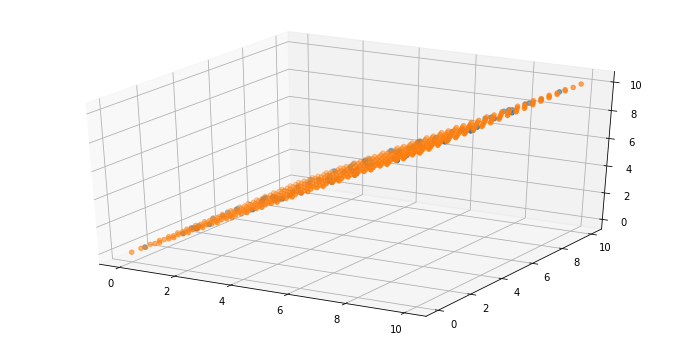

In [78]:

## generate test points for prediction
xx = np.linspace(0, 10, 20).reshape(20, 1)  # test points must be of shape (N, D)
xx_X, xx_Y = np.meshgrid(xx, xx)
xx = np.vstack((xx_X.flatten(), xx_Y.flatten())).T
print('xx', xx.shape)
## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)
print('mean', mean.shape)
# ## generate 10 samples from posterior
# tf.random.set_seed(1)  # for reproducibility
# samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)
## plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)
ax.scatter(xx[:,0],xx[:,1], mean)

# ax.fill_between(xx[:,0],
#                  mean[:,0] - 1.96 * np.sqrt(var[:,0]),
#                  mean[:,0] + 1.96 * np.sqrt(var[:,0]),
#                  color='C0', alpha=0.2)

# ax.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
# ax.xlim(-0.1, 1.1);

In [73]:

class GP_module(object):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.k1 = gpflow.kernels.SquaredExponential(active_dims=[0], lengthscale=1)
        self.k2 = gpflow.kernels.SquaredExponential(active_dims=[1], lengthscale=1)
        self.k = self.k1 + self.k2
        self.m = gpflow.models.GPR(data=(self.X, self.Y), kernel=self.k, mean_function=None)

    def objective_closure(self):
        return - self.m.log_marginal_likelihood()

In [76]:
GP_model = GP_module(X,Y)
opt_logs = opt.minimize(GP_model.objective_closure,
                                GP_model.m.trainable_variables,
                                options=dict(maxiter=100))
print_summary(m)

╒═══════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                              │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 103434     │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].lengthscale │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │    576.497 │
├───────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].variance    │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │      

In [80]:
m.predict_log_density([X,Y])

<tf.Tensor: shape=(100, 1), dtype=float64, numpy=
array([[5.94449511],
       [5.94822939],
       [5.95163429],
       [5.95479653],
       [5.9576317 ],
       [5.96030224],
       [5.96266109],
       [5.96477456],
       [5.96673021],
       [5.9684556 ],
       [5.97003869],
       [5.9714411 ],
       [5.9726309 ],
       [5.97375925],
       [5.97469512],
       [5.97555431],
       [5.97626106],
       [5.97688133],
       [5.9774387 ],
       [5.9778559 ],
       [5.97820539],
       [5.97851748],
       [5.97872125],
       [5.97886007],
       [5.9789988 ],
       [5.9791511 ],
       [5.97915356],
       [5.97923452],
       [5.97918714],
       [5.9791605 ],
       [5.97911873],
       [5.97903186],
       [5.97895715],
       [5.97888022],
       [5.97877758],
       [5.97867846],
       [5.97855893],
       [5.97845546],
       [5.97835261],
       [5.97827744],
       [5.978166  ],
       [5.97808123],
       [5.97800854],
       [5.97790461],
       [5.97785375],
     

In [84]:
a = np.array([[1,2], [3,4]])
b = np.array([1,2])
np.delete(a,np.where(a==b))

array([3, 4])

In [87]:
import tensorflow_probability as tfp
from gpflow.utilities import print_summary, set_trainable, to_default_float
k = gpflow.kernels.Matern32()
k.variance.prior = tfp.distributions.Gamma(
    to_default_float(2), to_default_float(3))

print_summary(k)

╒══════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                 │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞══════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Matern32.variance    │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │       1 │
├──────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Matern32.lengthscale │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘══════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛
